In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.inspection import permutation_importance
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler

## Date Processing

### JKP processing

In [3]:
# --- Load and filter JKP data from 2005 onwards ---
jkp_long = pd.read_csv("[usa]_[all_factors]_[monthly]_[vw_cap].csv", parse_dates=["date"])
jkp_wide = jkp_long.pivot(index="date", columns="name", values="ret")
jkp_wide = jkp_wide[jkp_wide.index >= '2005-01-01']

# --- Drop columns (factors) with more than 30% missing values ---
missing_ratio = jkp_wide.isnull().mean()
jkp_filtered = jkp_wide.loc[:, missing_ratio < 0.3]
n_dropped = (missing_ratio >= 0.3).sum()
print('The number of dropped factors due to high missing ratio:', n_dropped)

# --- Apply winsorization to reduce the effect of outliers ---
def winsorize_df(df, lower_pct=0.01, upper_pct=0.99):
    df_winsorized = df.copy()
    for col in df.columns:
        lower = df[col].quantile(lower_pct)
        upper = df[col].quantile(upper_pct)
        df_winsorized[col] = np.clip(df[col], lower, upper)
    return df_winsorized

jkp_winsorized = winsorize_df(jkp_filtered, lower_pct=0.01, upper_pct=0.99)

# --- Remove factors with near-zero variance (less informative) ---
variances = jkp_winsorized.var()
low_var_cols = variances[variances < 1e-5].index
jkp_var_filtered = jkp_winsorized.drop(columns=low_var_cols)
print('The dropped factors due to low variance:', len(low_var_cols))

# --- Drop one of each pair of highly correlated factors (correlation > 0.9) ---
corr_matrix = jkp_var_filtered.corr().abs()
upper_triangle = np.triu(corr_matrix, k=1)
upper_df = pd.DataFrame(upper_triangle, index=corr_matrix.index, columns=corr_matrix.columns)
threshold = 0.9
to_drop = [column for column in upper_df.columns if any(upper_df[column] > threshold)]
jkp_corr_filtered = jkp_var_filtered.drop(columns=to_drop)
print('The number of dropped factors due to high correlation:', len(to_drop))

# --- Select specific set of factors to be used in analysis ---
selected_factors = [
    'beta_60m', 'bidaskhl_21d', 'dolvol_var_126d', 'ebitda_mev', 'f_score',
    'inv_gr1', 'kz_index', 'ni_me', 'o_score', 'prc_highprc_252d',
    'qmj', 'qmj_growth', 'resff3_6_1', 'ret_12_1', 'ret_3_1', 'ret_6_1',
    'sale_me', 'z_score'
]

# --- Keep only selected factors and reset index ---
columns_to_keep = ['date'] + selected_factors
columns_existing = [col for col in columns_to_keep if col in jkp_corr_filtered.columns]
jkp_selected = jkp_corr_filtered[columns_existing]
jkp_selected = jkp_selected.reset_index()

The number of dropped factors due to high missing ratio: 0
The dropped factors due to low variance: 0
The number of dropped factors due to high correlation: 43


### Compustat Processing

In [38]:
# --- Load and filter Compustat data from 2005 onwards ---
df = pd.read_csv("CompFirmCharac.csv")
df['datadate'] = pd.to_datetime(df['datadate'], errors='coerce')
df_500 = df[df['datadate'].dt.year >= 2005]

# --- Keep only firms in the S&P500 index ---
sp500_firms = [1013, 1075, 1078, 1161, 1177, 1209, 1239, 1240, 1279, 1300, 1318, 1356, 1380, 1408, 1440, 1447, 1449, 1478, 1487, 1567, 1602, 1619, 1632, 1651, 1661, 1663, 1678, 1690, 1704, 1722, 1794, 1878, 1891, 1913, 1920, 1976, 1988, 1995, 2019, 2044, 2085, 2086, 2111, 2136, 2146, 2154, 2184, 2230, 2255, 2269, 2285, 2290, 2312, 2403, 2435, 2444, 2490, 2504, 2547, 2574, 2663, 2710, 2751, 2783, 2817, 2845, 2849, 2884, 2968, 2991, 3011, 3024, 3054, 3062, 3105, 3121, 3144, 3170, 3221, 3226, 3231, 3243, 3278, 3310, 3336, 3362, 3413, 3439, 3497, 3502, 3505, 3532, 3555, 3650, 3734, 3735, 3813, 3835, 3897, 3964, 3980, 4016, 4029, 4040, 4058, 4060, 4062, 4066, 4087, 4093, 4145, 4194, 4199, 4213, 4242, 4321, 4367, 4371, 4423, 4503, 4517, 4560, 4598, 4601, 4611, 4640, 4674, 4699, 4723, 4737, 4739, 4818, 4839, 4843, 4885, 4988, 4990, 5046, 5047, 5071, 5073, 5074, 5125, 5216, 5229, 5234, 5250, 5256, 5439, 5518, 5568, 5589, 5597, 5606, 5643, 5680, 5723, 5742, 5786, 5860, 5878, 5959, 6008, 6066, 6078, 6081, 6097, 6104, 6136, 6241, 6266, 6268, 6304, 6307, 6310, 6375, 6403, 6435, 6475, 6502, 6529, 6649, 6669, 6730, 6733, 6742, 6768, 6774, 6781, 6799, 6821, 6829, 7017, 7065, 7067, 7085, 7116, 7139, 7146, 7154, 7163, 7171, 7186, 7228, 7238, 7241, 7257, 7260, 7267, 7343, 7366, 7409, 7435, 7506, 7585, 7620, 7637, 7647, 7648, 7711, 7750, 7772, 7866, 7875, 7881, 7904, 7906, 7922, 7923, 7974, 7977, 7982, 7985, 8007, 8030, 8068, 8099, 8245, 8247, 8253, 8264, 8272, 8304, 8358, 8402, 8446, 8455, 8470, 8479, 8488, 8530, 8536, 8539, 8543, 8549, 8606, 8762, 8787, 8810, 8823, 8972, 9004, 9063, 9203, 9217, 9258, 9299, 9351, 9359, 9372, 9411, 9459, 9465, 9483, 9555, 9667, 9699, 9778, 9783, 9846, 9850, 9882, 9899, 10016, 10035, 10096, 10115, 10121, 10156, 10187, 10190, 10232, 10247, 10277, 10332, 10391, 10405, 10420, 10426, 10453, 10499, 10507, 10519, 10530, 10614, 10726, 10787, 10793, 10860, 10867, 10903, 10920, 10974, 10983, 10984, 11060, 11220, 11228, 11259, 11264, 11366, 11446, 11456, 11465, 11506, 11609, 11636, 11672, 11687, 11818, 11856, 11910, 11923, 11925, 12053, 12123, 12124, 12136, 12138, 12141, 12142, 12216, 12233, 12338, 12389, 12540, 12635, 12689, 12726, 12756, 12884, 12886, 13041, 13204, 13341, 13498, 13561, 13646, 13714, 13988, 14256, 14324, 14477, 14489, 14535, 14565, 14590, 14623, 14624, 14650, 14824, 14934, 14960, 15084, 15202, 15208, 15247, 15521, 15708, 15709, 15855, 16243, 16478, 16721, 17110, 17130, 18699, 20423, 20779, 22140, 22260, 22325, 22794, 23592, 23809, 23877, 23943, 23978, 24008, 24032, 24216, 24287, 24318, 24379, 24468, 24607, 24800, 24856, 25056, 25124, 25157, 25279, 25283, 25338, 25340, 25356, 25434, 25495, 25880, 26011, 27845, 27914, 27928, 28034, 28139, 28195, 28256, 28338, 28349, 28733, 28930, 29028, 29095, 29241, 29345, 29389, 29392, 29791, 29984, 30128, 30490, 30697, 30865, 30990, 31122, 31166, 31549, 31673, 31846, 61489, 61552, 61574, 61591, 61676, 61739, 62599, 62634, 62689, 63180, 63501, 63669, 63766, 63800, 63892, 64156, 64166, 64356, 64768, 65048, 65417, 65904, 66708, 66731, 110685, 112033, 113419, 114524, 114628, 117768, 119417, 120877, 125533, 126554, 133768, 135484, 136648, 137232, 139662, 139665, 140541, 140760, 143356, 144066, 144559, 145046, 145701, 149738, 157858, 158354, 160255, 164708]
sp500_firms_str = [str(x) for x in sp500_firms]
df_500['gvkey'] = df_500['gvkey'].astype(str)
df_500 = df_500[df_500['gvkey'].isin(sp500_firms_str)]

# --- Keep only firms with data up to at least 2024-10-31 ---
end_date = pd.to_datetime("2024-10-31")
df_500['datadate'] = pd.to_datetime(df_500['datadate'], errors='coerce')
latest_dates = df_500.groupby('gvkey')['datadate'].max()
valid_gvkeys = latest_dates[latest_dates >= end_date].index
df_500 = df_500[df_500['gvkey'].isin(valid_gvkeys)].copy()

# --- Remove records after cutoff date and create 'date' column ---
cutoff_date = pd.to_datetime("2024-10-31")
df_500 = df_500[df_500['datadate'] <= cutoff_date].copy()
df_500['date'] = df_500['datadate'] + pd.offsets.MonthEnd(0)

# --- Clean and sort data ---
id_column = 'gvkey' if 'gvkey' in df_500.columns else 'cik'
comp_df_cleaned = df_500.dropna(subset=['date', id_column])
comp_df_cleaned = comp_df_cleaned.sort_values(by=['date', id_column])

# --- Identify numeric columns for filtering ---
numeric_cols = comp_df_cleaned.select_dtypes(include=['int64', 'float64']).columns

# --- Drop columns with too many missing values or constants ---

#na < 15000 (half of the total rows)
na_columns = [
    'fuseoy', 'unwccy', 'utfdocy', 'utfoscy', 'uwkcapcy', 'wcapchy', 'wcapcy', 'ufretsdy', 'ustdncy',
    'tsafcy', 'fsrcty', 'fusety', 'fsrcoy', 'fopty', 'arcedy', 'arceepsy', 'arcey', 'gdwlamy', 'utmey',
    'amcy', 'ffoy', 'srety', 'nimy', 'dprety', 'itccy', 'udfccy', 'finxopry', 'finxinty', 'afudciy',
    'afudccy', 'finrevy', 'pdvcy', 'esuby', 'plly', 'niity', 'tiey', 'tiiy', 'ncoy', 'usubdvpy',
    'gdwliepsy', 'gdwlidy', 'prstkccy', 'gdwliay', 'rrdy', 'rrepsy', 'gdwlipy', 'rray', 'rrpy',
    'tdcy', 'uspiy', 'prstkpcy', 'scstkcy', 'udvpy', 'uoisy', 'depcy', 'uaolochy', 'ugiy', 'spstkcy',
    'unopincy', 'uniamiy', 'updvpy', 'cdvcy', 'uptacy', 'wdepsy', 'wddy', 'wday', 'wdpy', 'glivy',
    'glepsy', 'gldy', 'glay', 'glpy', 'dteepsy', 'dtedy', 'dteay', 'dtepy', 'derhedgly', 'hedgegly',
    'setepsy', 'setdy', 'setay', 'setpy', 'nrtxtepsy', 'nrtxtdy', 'nrtxty', 'spiepsy', 'spidy',
    'spioay', 'spiopy', 'txdiy', 'fcay', 'aqepsy', 'aqdy', 'aqay', 'aqpy', 'optfvgry', 'glceepsy',
    'glcedy', 'glceay', 'glcepy', 'optdry', 'optlifey', 'optrfry', 'optvoly', 'stkcpay', 'pncidy',
    'pnciepsy', 'pncwidy', 'pncwiepsy', 'pnciay', 'pncipy', 'pncwiay', 'pncwipy', 'tfvcey', 'xrdy',
    'pncidpy', 'pnciepspy', 'pncwiepy', 'pncwidpy', 'pnciapy', 'pncippy', 'pncwippy', 'pncwiapy',
    'rcepsy', 'rcdy', 'rcay', 'spcedy', 'spceepsy', 'rcpy', 'spcedpy', 'spceepspy', 'spcey', 'spcepy'
]

#unique counts < 2
constant_columns = [
    'fopty', 'uwkcapcy', 'wcapchy', 'wcapcy', 'ustdncy', 'unwccy',
    'utfdocy', 'tsafcy', 'ufretsdy', 'fusety', 'fuseoy', 'fsrcty',
    'fsrcoy', 'utfoscy', 'gdwlamy', 'updvpy'
]
selected_columns = list(set(numeric_cols) - set(na_columns) - set(constant_columns))

# --- Winsorize and standardize selected features ---
df_num = comp_df_cleaned[['gvkey', 'datadate'] + selected_columns]
df_num = df_num.set_index(['gvkey','datadate'])
for col in selected_columns:
    if pd.api.types.is_numeric_dtype(df_num[col]):
        nan_mask = df_num[col].isnull()
        valid_series = df_num[col].dropna()
        winsorized_array = winsorize(valid_series.to_numpy(), limits=[0.01, 0.01])
        df_num.loc[~nan_mask, col] = pd.Series(winsorized_array, index=valid_series.index)

scaler = StandardScaler()
df_scaled = df_num.copy()
df_scaled[selected_columns] = scaler.fit_transform(df_num[selected_columns])

# --- Drop highly correlated features ---
selected_columns = [col for col in selected_columns if col not in ['rdipay', 'acchgy', 'rdipy', 'rdipdy', 'rdipepsy', 'txwy']]
correlation_matrix = df_scaled[selected_columns].corr()
highly_correlated_pairs = []
temp_highly_correlated_vars_set = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        col1 = correlation_matrix.columns[i]
        col2 = correlation_matrix.columns[j]
        correlation_value = correlation_matrix.iloc[i, j]
        if abs(correlation_value) >= 0.7:
            highly_correlated_pairs.append(((col1, col2), correlation_value))
            temp_highly_correlated_vars_set.add(col1)
            temp_highly_correlated_vars_set.add(col2)

highly_correlated_vals = list(temp_highly_correlated_vars_set)
duplicated_var = [col for col in highly_correlated_vals if col not in ['xoptdy','xinty','niy','revty','epspiy','cshpry','dpy']]
selected_columns = [col for col in selected_columns if col not in duplicated_var]

# --- Extract relevant columns for analysis ---
columns_to_extract = [
    'datadate','gvkey','cusip','fqtr', 'cstkey', 'cicurry', 'dilady', 'niy', 'nopiy', 'invchy', 'esubcy', 'apalchy', 'aolochy',
    'exrey', 'spiy', 'aqcy', 'ivstchy', 'txbcoy', 'fyr', 'recchy', 'txbcofy', 'cisecgly', 'xoptdy',
    'xidocy', 'xiy', 'fiaoy', 'cipeny', 'revty', 'txdcy', 'xinty', 'ivncfy', 'sstky', 'dlcchy',
    'fyearq', 'cidergly', 'exchg', 'ivacoy', 'fincfy', 'cik', 'epspiy', 'dpy', 'sppivy', 'chechy',
    'ciothery', 'prstkcy', 'cshpry', 'txachy', 'sppey'
]
df_selected = comp_df_cleaned[[col for col in columns_to_extract if col in comp_df_cleaned.columns]]
df_selected['datadate'] = pd.to_datetime(df_selected['datadate'], errors='coerce')

# --- Expand quarterly data to next three months (t+1, t+2, t+3) ---

expanded_rows = []

for _, row in df_selected.iterrows():
    base_date = row['datadate']
    for offset in range(1, 4):
        date = (base_date + pd.DateOffset(months=offset)).replace(day=1) + pd.offsets.MonthEnd(0)
        new_row = row.copy()
        new_row['date'] = date
        expanded_rows.append(new_row)

comp_selected = pd.DataFrame(expanded_rows)
comp_selected = comp_selected.sort_values(by=['date'])

/var/folders/_s/jd19jm5x0bj6k6nfh5q_1n700000gn/T/ipykernel_68526/647175940.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CompFirmCharac.csv")
/var/folders/_s/jd19jm5x0bj6k6nfh5q_1n700000gn/T/ipykernel_68526/647175940.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500['gvkey'] = df_500['gvkey'].astype(str)
/var/folders/_s/jd19jm5x0bj6k6nfh5q_1n700000gn/T/ipykernel_68526/647175940.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

### Merge JKP with Compustat

In [50]:
# --- Step 1: Prepare datasets ---
comp = comp_selected
jkp = jkp_selected

# Convert 'date' columns to datetime format
jkp['date'] = pd.to_datetime(jkp['date'], errors='coerce')
comp['date'] = pd.to_datetime(comp['date'], errors='coerce')

# --- Step 2: Merge JKP factors into Compustat data by date ---
# Left join on date to align macro-level JKP factors to firm-level Compustat data
merged = comp.merge(jkp, on='date', how='left')

# Identify numeric feature columns (excluding identifiers and date)
non_feature_cols = ['date', 'gvkey', 'cik']
feature_cols = [col for col in merged.columns if col not in non_feature_cols and pd.api.types.is_numeric_dtype(merged[col])]

# --- Step 3: Handle missing values and standardize features ---
# Fill missing values with median
merged[feature_cols] = merged[feature_cols].fillna(merged[feature_cols].median())

# Standardize features
scaler = StandardScaler()
merged_scaled = merged.copy()
merged_scaled[feature_cols] = scaler.fit_transform(merged[feature_cols])

# --- Step 4: Remove highly correlated features ---
# Compute correlation matrix
corr_matrix = merged_scaled[feature_cols].corr().abs()

# Extract upper triangle to avoid duplicate checks
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop (correlation > 0.95)
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop highly correlated features
merged_jkp_comp = merged_scaled.drop(columns=to_drop)

# --- Step 5: Investigate duplicate CUSIPs within the same gvkey ---
# Count number of unique CUSIPs per gvkey
gvkey_cusip_counts = merged_jkp_comp.groupby('gvkey')['cusip'].nunique()

# Identify gvkeys with multiple CUSIPs
multi_cusip_gvkeys = gvkey_cusip_counts[gvkey_cusip_counts > 1].index

# Filter for rows corresponding to those gvkeys
merged_multi_cusip = merged_jkp_comp[merged_jkp_comp['gvkey'].isin(multi_cusip_gvkeys)]

# --- Step 6: Derive 8-digit CUSIP for matching with CRSP ---
merged_jkp_comp['cusip'] = merged_jkp_comp['cusip'].astype(str)
merged_jkp_comp['cusip8'] = merged_jkp_comp['cusip'].str[:8]

# Check number of unique 8-digit CUSIPs
unique_cusip8_count = merged_jkp_comp['cusip8'].nunique()
print(f"Number of unique cusip8: {unique_cusip8_count}")

Number of unique cusip8: 321


In [51]:
merged_jkp_comp

,datadate,gvkey,cusip,fqtr,cstkey,cicurry,dilady,niy,nopiy,invchy,...,prc_highprc_252d,qmj,qmj_growth,resff3_6_1,ret_12_1,ret_3_1,ret_6_1,sale_me,z_score,cusip8
0,2005-01-31,11259,931142103,1.358545,0.101646,0.078191,-0.102176,1.952645,0.225753,-0.520806,...,0.566743,0.714602,1.909322,0.663081,1.09746,-0.197550,0.216065,0.669195,-0.652538,93114210
1,2005-01-31,1878,052769106,1.358545,0.101646,0.078191,-0.102176,-0.299722,-0.004486,0.053123,...,0.566743,0.714602,1.909322,0.663081,1.09746,-0.197550,0.216065,0.669195,-0.652538,05276910
2,2005-01-31,1632,032654105,-1.335247,0.101646,0.080290,-0.102176,-0.325297,-0.000854,0.049002,...,0.566743,0.714602,1.909322,0.663081,1.09746,-0.197550,0.216065,0.669195,-0.652538,03265410
3,2005-01-31,126554,00846U101,-1.335247,0.101646,0.151495,-0.102176,-0.326294,0.008745,0.045118,...,0.566743,0.714602,1.909322,0.663081,1.09746,-0.197550,0.216065,0.669195,-0.652538,00846U10
4,2005-01-31,11672,872540109,1.358545,0.101646,0.078191,-0.102176,-0.200476,-0.011185,-0.032858,...,0.566743,0.714602,1.909322,0.663081,1.09746,-0.197550,0.216065,0.669195,-0.652538,87254010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76192,2024-10-31,64356,171779309,1.358545,0.101646,0.070626,-0.102176,-0.330564,0.025914,0.085344,...,0.054391,-0.001764,0.071571,0.025748,0.07776,0.026965,-0.007726,-0.047344,0.046440,17177930
76193,2024-10-31,5680,437076102,0.460614,0.101646,-0.933413,-0.102176,2.298388,0.115035,-0.189470,...,0.054391,-0.001764,0.071571,0.025748,0.07776,0.026965,-0.007726,-0.047344,0.046440,43707610
76194,2024-10-31,5606,40434L105,1.358545,0.101646,0.136834,-0.102176,0.272814,0.041222,-0.133160,...,0.054391,-0.001764,0.071571,0.025748,0.07776,0.026965,-0.007726,-0.047344,0.046440,40434L10
76195,2024-10-31,14489,24703L202,0.460614,0.101646,-0.153941,-0.102176,0.336491,0.024984,-0.670169,...,0.054391,-0.001764,0.071571,0.025748,0.07776,0.026965,-0.007726,-0.047344,0.046440,24703L20


### Merge JKP & Compustat data with Monthly CRSP

In [53]:
# --- Step 1: Load and preprocess CRSP monthly return data ---
crsp = pd.read_csv("monthly_crsp.csv")

# Convert MthCalDt to datetime format
crsp['date'] = pd.to_datetime(crsp['MthCalDt'], errors='coerce')

# Filter CRSP data to include only entries from 2005 to 2024
start_date = pd.to_datetime("2005-02-28")
end_date = pd.to_datetime("2024-12-31")
crsp_filtered = crsp[(crsp['date'] >= start_date) & (crsp['date'] <= end_date)].copy()

# --- Step 2: Filter CRSP data to include only firms that exist in merged_jkp_comp ---
# Extract unique 8-digit CUSIPs from merged_jkp_comp
cusip_set = merged_jkp_comp['cusip8'].dropna().unique()

# Keep only rows in CRSP where CUSIP matches 8-digit CUSIPs from Compustat
crsp_matched = crsp_filtered[crsp_filtered['CUSIP'].isin(cusip_set)].copy()

# Convert date columns to datetime in case they were not
merged_jkp_comp['date'] = pd.to_datetime(merged_jkp_comp['date'], errors='coerce')
crsp_matched['date'] = pd.to_datetime(crsp_matched['date'], errors='coerce')

# Create 8-digit CUSIP for merging
crsp_matched['cusip8'] = crsp_matched['CUSIP'].str[:8]

# --- Step 3: Merge firm-level data (Compustat + JKP) with market return data (CRSP) ---
# Merge on both date and 8-digit CUSIP
merged_data = pd.merge(
    merged_jkp_comp,
    crsp_matched,
    left_on=['date', 'cusip8'],
    right_on=['date', 'cusip8'],
    how='inner'  # Use 'inner' to retain only matching records
)

# --- Step 4: Save the merged dataset for modeling ---
merged_data.to_csv("merged_data.csv", index=False)

In [55]:
merged_data['date']

0       2005-02-28
1       2005-02-28
2       2005-02-28
3       2005-02-28
4       2005-02-28
           ...    
45932   2024-12-31
45933   2024-12-31
45934   2024-12-31
45935   2024-12-31
45936   2024-12-31
Name: date, Length: 45937, dtype: datetime64[ns]

## Modeling

### Data Preparation and Splitting for Stock Return Prediction Model

In [56]:
# Step 1: Load preprocessed merged dataset (Compustat + JKP + CRSP)
df = merged_data.copy()

# Step 2: Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Step 3: Specify columns to be dropped (identifiers and non-predictive columns)
drop_columns = [
    'datadate', 'gvkey', 'cusip', 'cusip8', 'cik',
    'PERMNO', 'PERMCO', 'CUSIP', 'HdrCUSIP',
    'Ticker', 'TradingSymbol', 'MthCalDt', 'sprtrn',
    'SICCD', 'NAICS', 'date'
]

# Step 4: Define feature matrix X and target vector y
X = df.drop(columns=drop_columns + ['MthRet']).fillna(0)  # Use all remaining columns as features
y = df['MthRet']  # Monthly stock return as target variable

# Step 5: Remove rows where the target (y) is missing
valid_mask = ~y.isna()
X = X[valid_mask]
y = y[valid_mask]
df = df[valid_mask]

# Step 6: Create date-based masks for train, validation, and test splits
train_mask = df['date'] < '2017-01-01'
val_mask   = (df['date'] >= '2017-01-01') & (df['date'] < '2021-01-01')
test_mask  = df['date'] >= '2021-01-01'

# Step 7: Apply masks to split the dataset
X_train = X[train_mask]
y_train = y[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]

### Hyperparameter Optimization for MLP Regressor Using RandomizedSearchCV

In [57]:
# Step 1: Define the hyperparameter search space for MLP
param_dist = {
    'hidden_layer_sizes': [(32,), (64,), (32, 16), (64, 32), (64, 32, 16)],  # Different layer configurations
    'alpha': np.linspace(0.0001, 0.2, 20),  # Regularization strength (L2 penalty)
    'early_stopping': [False],  # No early stopping for fair cross-validation
    'max_iter': [1000]  # Maximum number of training iterations
}

# Step 2: Initialize the MLPRegressor
mlp = MLPRegressor(random_state=42)

# Step 3: Set up RandomizedSearchCV to find best hyperparameters
random_search_mlp = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=20,           # Number of random combinations to try
    cv=3,                # 3-fold cross-validation
    scoring='r2',        # Maximize R² score
    random_state=42,
    n_jobs=-1,           # Use all available CPU cores
    verbose=1            # Print progress during search
)

# Step 4: Run the search on the training data
random_search_mlp.fit(X_train, y_train)

# Step 5: Store and display the best hyperparameters and corresponding score
best_params = random_search_mlp.best_params_
print("Best Parameters for MLP:")
print(random_search_mlp.best_params_)
print(f"Best R² on Validation: {random_search_mlp.best_score_:.5f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters for MLP:
{'max_iter': 1000, 'hidden_layer_sizes': (64, 32), 'early_stopping': False, 'alpha': 0.16843684210526316}
Best R² on Validation: 0.16342


### Hyperparameter Optimization for XGBoost Regressor Using RandomizedSearchCV

In [67]:
# Step 1: Define the hyperparameter search space for XGBoost
param_dist_xgb = {
    'n_estimators': np.arange(100, 500, 50),           # Number of trees
    'learning_rate': np.linspace(0.01, 0.3, 10),       # Learning rate
    'max_depth': np.arange(3, 10),                     # Maximum depth of trees
    'subsample': np.linspace(0.6, 1.0, 5),             # Row sampling
    'colsample_bytree': np.linspace(0.6, 1.0, 5),      # Column sampling per tree
    'reg_alpha': np.linspace(0, 1, 10),                # L1 regularization
    'reg_lambda': np.linspace(0, 1, 10)                # L2 regularization
}

# Step 2: Initialize the XGBoost Regressor
xgb = XGBRegressor(random_state=42, n_jobs=-1)

# Step 3: Set up RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,              # Number of random combinations to try
    cv=3,                   # 3-fold cross-validation
    scoring='r2',           # Maximize R² score
    random_state=42,
    verbose=1,
    n_jobs=-1               # Use all available CPU cores
)

# Step 4: Fit the model on the training data
random_search_xgb.fit(X_train, y_train)

# Step 5: Save the best parameters
best_params_xgb = random_search_xgb.best_params_

# Step 6: Print the results
print("Best Parameters for XGBoost:")
print(best_params_xgb)
print(f"Best R² on Validation: {random_search_xgb.best_score_:.5f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters for XGBoost:
{'subsample': 0.6, 'reg_lambda': 0.8888888888888888, 'reg_alpha': 0.1111111111111111, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.042222222222222223, 'colsample_bytree': 0.6}
Best R² on Validation: 0.16457


### Model Comparison on Validation Set Using Optimized and Benchmark Parameters

In [ ]:


# Step 1: Define models with optimized parameters for MLP and XGBoost
# Lasso and DecisionTree are included as benchmark models
models = {
    "MLP": MLPRegressor(
        **best_params,  # Best MLP parameters from RandomizedSearchCV
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        **best_params_xgb,  # Best XGBoost parameters from RandomizedSearchCV
        random_state=42,
        n_jobs=-1
    ),
    "Lasso": Lasso(
        alpha=0.001,       # Manually set alpha (benchmark)
        max_iter=10000,
        random_state=42
    ),
    "DecisionTree": DecisionTreeRegressor(
        max_depth=5,       # Manually set max depth (benchmark)
        random_state=42
    )
}

# Step 2: Prepare to store evaluation results
results = []

# Step 3: Train each model, predict on validation set, and compute metrics
for name, model in models.items():
    model.fit(X_train, y_train)                # Train the model
    y_val_pred = model.predict(X_val)          # Predict on validation data
    
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))  # Compute RMSE
    r2 = r2_score(y_val, y_val_pred)                       # Compute R² score
    
    # Save the results
    results.append({
        "Model": name,
        "Validation RMSE": round(rmse, 5),
        "Validation R²": round(r2, 5)
    })

# Step 4: Convert results to DataFrame and display
df_results = pd.DataFrame(results)
print(df_results)

          Model  Validation RMSE  Validation R²
0           MLP          0.12730        0.13454
1       XGBoost          0.12865        0.11605
2         Lasso          0.12652        0.14517
3  DecisionTree          0.12842        0.11919


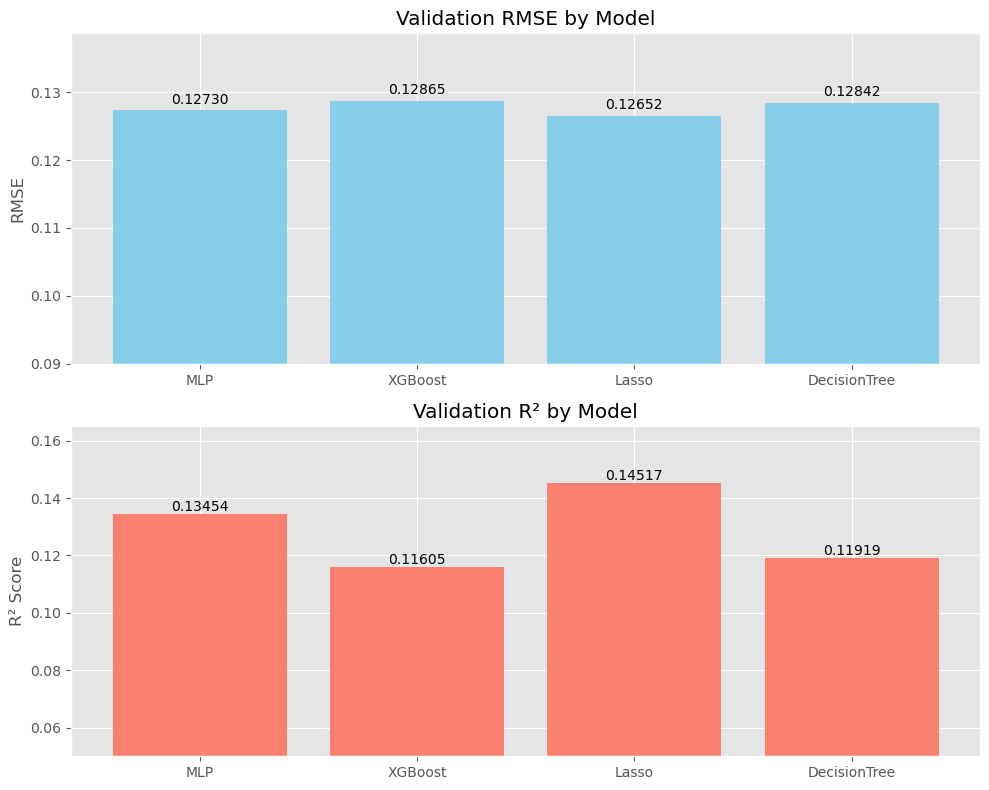

In [65]:
# Set plot style
plt.style.use('ggplot')

# Create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot Validation RMSE
axes[0].bar(df_results['Model'], df_results['Validation RMSE'], color='skyblue')
axes[0].set_title("Validation RMSE by Model")
axes[0].set_ylabel("RMSE")
axes[0].set_ylim([0.09, df_results['Validation RMSE'].max() + 0.01])
for i, v in enumerate(df_results['Validation RMSE']):
    axes[0].text(i, v + 0.001, f"{v:.5f}", ha='center')

# Plot Validation R²
axes[1].bar(df_results['Model'], df_results['Validation R²'], color='salmon')
axes[1].set_title("Validation R² by Model")
axes[1].set_ylabel("R² Score")
axes[1].set_ylim([0.05, df_results['Validation R²'].max() + 0.02])
for i, v in enumerate(df_results['Validation R²']):
    axes[1].text(i, v + 0.001, f"{v:.5f}", ha='center')

# Final layout adjustment
plt.tight_layout()
plt.show()

### Final Model Evaluation on Test Set using Lasso and MLP

In [60]:
# Combine training and validation data for extended training set
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# List to store test evaluation results
results = []

# ========== Lasso Regression ==========
# 1. Trained on Train only
lasso_train = Lasso(alpha=0.001, max_iter=10000)
lasso_train.fit(X_train, y_train)
y_pred_lasso_train = lasso_train.predict(X_test)

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso_train))
r2 = r2_score(y_test, y_pred_lasso_train)
results.append({'Model': 'Lasso (Train)', 'Test RMSE': rmse, 'Test R²': r2})

# 2. Trained on Train + Validation
lasso_all = Lasso(alpha=0.001, max_iter=10000)
lasso_all.fit(X_train_val, y_train_val)
y_pred_lasso_all = lasso_all.predict(X_test)

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso_all))
r2 = r2_score(y_test, y_pred_lasso_all)
results.append({'Model': 'Lasso (Train+Val)', 'Test RMSE': rmse, 'Test R²': r2})

# ========== MLP (Neural Network) ==========
# 1. Trained on Train only using best parameters
mlp_train = MLPRegressor(**best_params, random_state=42)
mlp_train.fit(X_train, y_train)
y_pred_mlp_train = mlp_train.predict(X_test)

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_mlp_train))
r2 = r2_score(y_test, y_pred_mlp_train)
results.append({'Model': 'MLP (Train)', 'Test RMSE': rmse, 'Test R²': r2})

# 2. Trained on Train + Validation using best parameters
mlp_all = MLPRegressor(**best_params, random_state=42)
mlp_all.fit(X_train_val, y_train_val)
y_pred_mlp_all = mlp_all.predict(X_test)

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_mlp_all))
r2 = r2_score(y_test, y_pred_mlp_all)
results.append({'Model': 'MLP (Train+Val)', 'Test RMSE': rmse, 'Test R²': r2})

# Show results as DataFrame
results_df = pd.DataFrame(results)
print(results_df)

               Model  Test RMSE   Test R²
0      Lasso (Train)   0.094490  0.083149
1  Lasso (Train+Val)   0.094544  0.082105
2        MLP (Train)   0.094637  0.080301
3    MLP (Train+Val)   0.093830  0.095919


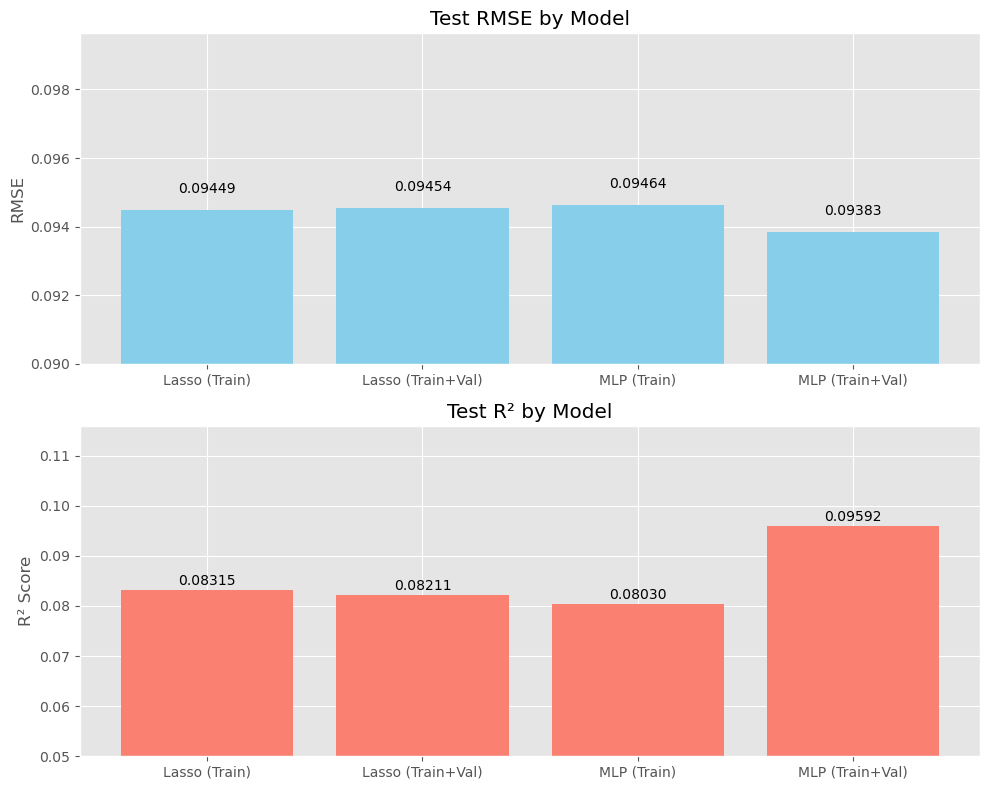

In [66]:

# Set plot style
plt.style.use('ggplot')

# Create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot RMSE comparison
axes[0].bar(results_df['Model'], results_df['Test RMSE'], color='skyblue')
axes[0].set_title("Test RMSE by Model")
axes[0].set_ylabel("RMSE")
axes[0].set_ylim([0.09, results_df['Test RMSE'].max() + 0.005])
for i, v in enumerate(results_df['Test RMSE']):
    axes[0].text(i, v + 0.0005, f"{v:.5f}", ha='center')

# Plot R² comparison
axes[1].bar(results_df['Model'], results_df['Test R²'], color='salmon')
axes[1].set_title("Test R² by Model")
axes[1].set_ylabel("R² Score")
axes[1].set_ylim([0.05, results_df['Test R²'].max() + 0.02])
for i, v in enumerate(results_df['Test R²']):
    axes[1].text(i, v + 0.001, f"{v:.5f}", ha='center')

# Adjust layout
plt.tight_layout()
plt.show()

### Feature Selection using Permutation Importance for MLP Model

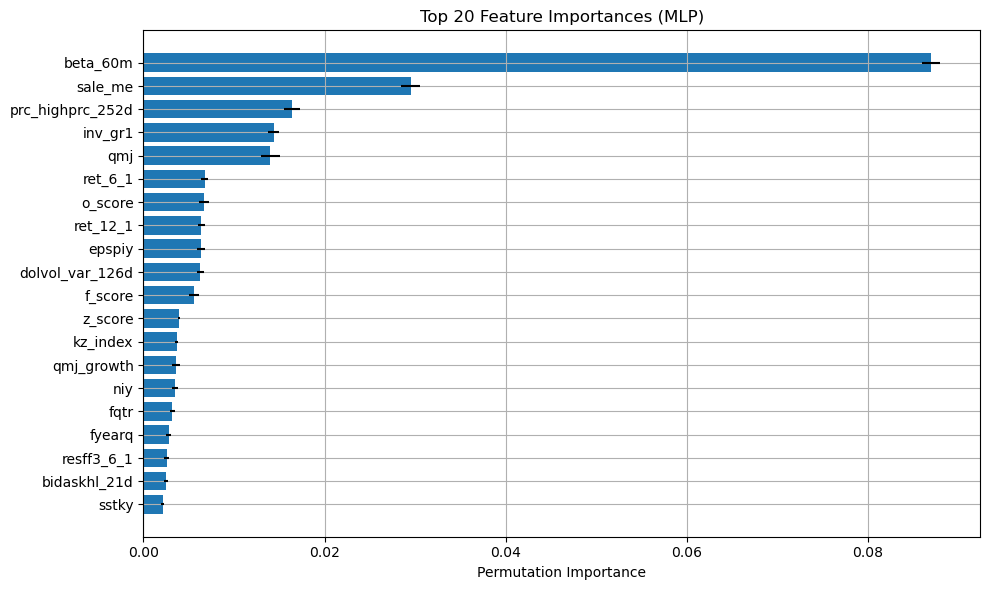


Selected 24 features above threshold 0.001


In [62]:
# --- 1. Combine training and validation sets ---
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# --- 2. Train MLP model with optimized parameters ---
mlp = MLPRegressor(**best_params, random_state=42)
mlp.fit(X_train_val, y_train_val)

# --- 3. Compute permutation importance on train+val data ---
result = permutation_importance(
    estimator=mlp,
    X=X_train_val,
    y=y_train_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# --- 4. Organize results into a DataFrame ---
importances = pd.DataFrame({
    'Feature': X_train_val.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# --- 5. Visualize top N most important features ---
top_n = 20
top_importances = importances.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(
    top_importances['Feature'][::-1],
    top_importances['Importance Mean'][::-1],
    xerr=top_importances['Importance Std'][::-1]
)
plt.xlabel("Permutation Importance")
plt.title(f"Top {top_n} Feature Importances (MLP)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6. Select features with importance above threshold ---
threshold = 0.001
selected_features = importances[importances['Importance Mean'] >= threshold]['Feature'].tolist()
print(f"\nSelected {len(selected_features)} features above threshold {threshold}")

### Hyperparameter Optimization for MLP with Selected Features

In [63]:
# --- 1. Define hyperparameter search space ---
param_dist = {
    'hidden_layer_sizes': [(16,), (32, 16), (64, 32)],  # Different layer configurations
    'alpha': np.linspace(0.0001, 0.2, 20),              # Regularization strengths
    'early_stopping': [False],                          # No early stopping
    'max_iter': [1000]                                  # Max training iterations
}

# --- 2. Initialize MLPRegressor for tuning ---
mlp = MLPRegressor(random_state=42)

# --- 3. Setup RandomizedSearchCV with R² as the scoring metric ---
random_search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=20,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# --- 4. Fit model using only selected features on combined train+val data ---
random_search.fit(X_train_val[selected_features], y_train_val)

# --- 5. Store and display the best hyperparameters found ---
best_params_mlp_selected = random_search.best_params_
print("Best Parameters (Selected Features):", best_params_mlp_selected)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters (Selected Features): {'max_iter': 1000, 'hidden_layer_sizes': (32, 16), 'early_stopping': False, 'alpha': 0.1579157894736842}


### Final Result

In [64]:
# 1. Train the final MLP model using the best hyperparameters and selected features
mlp_final_selected = MLPRegressor(**best_params_mlp_selected, random_state=42)
mlp_final_selected.fit(X_train_val[selected_features], y_train_val)

# 2. Predict the test set and evaluate performance
y_test_pred = mlp_final_selected.predict(X_test[selected_features])
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)

print(f"\nFinal MLP Test RMSE (optimized, selected features): {rmse:.5f}")
print(f"Final MLP Test R² (optimized, selected features): {r2:.5f}")


Final MLP Test RMSE (optimized, selected features): 0.09309
Final MLP Test R² (optimized, selected features): 0.11009
